Install libraries needed to run this notebook

In [1]:
!pip install fastdtw
!pip install tsfresh
!pip install sktime
!pip install pyts

     |████████████████████████████████| 92kB 5.9MB/s 
     |████████████████████████████████| 675kB 8.0MB/s 
     |████████████████████████████████| 92kB 11.6MB/s 
     |████████████████████████████████| 102kB 11.1MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=bcea799be08d7a20e5bc04244ccc9d80d3eaff57f82ccd41acd6da1255a00257
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4041 sha256=79bb935a840c71aadb5936d136a863ce522954daaa00834fbac08e945b1bdd06
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built contextvars locket
ERROR: tensorflow-probability 0.11.0 has requirement cloudpickle==1.3, but you'll have cloudpickle 1.6.0 which is incompatible.
ERROR: distributed 2020.12.0 has requirement dask>=2020.12.0, but you'll have dask 2.12.0 wh

In [2]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from scipy.stats import mode
from collections import Counter
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from fastdtw import fastdtw
from sktime.classification.compose import TimeSeriesForestClassifier
from pyts.transformation import BagOfPatterns

import torch
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

## Load in the training and testing data.
The data is located here: https://github.com/pradlanka/malini/tree/master/Functional%20connectivity%20data/ABIDE/Matched%20Split

Note, the excel file needs to be transposed

In [3]:
def preprocess_data(excel_file):
    data = pd.read_excel(excel_file)
    data.drop(['SpotID', 'Paths'], inplace=True, axis=1)
    data = data.T
    X = data[data.columns[1:]]
    y = data[0]
    return X, y

In [4]:
X_train, y_train = preprocess_data('sample_data/train_data.xlsx')
X_test, y_test = preprocess_data('sample_data/test_data.xlsx')

Lets explore the data

In [5]:
X_train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1318,1319,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343,1344,1345,1346,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356,1357
1,0.228086,0.0764402,0.22084,0.328754,0.00644437,0.359619,0.222506,-0.102592,0.162859,-0.201098,-0.397929,-0.615799,0.354701,0.151809,-0.16633,0.27843,-0.4498,0.77717,-0.422923,0.198219,0.150352,0.11182,0.387596,0.0090995,0.0680841,-0.353092,0.0774378,-0.144076,0.0163491,0.364927,0.184762,-0.312527,-0.217553,0.437898,0.043002,-0.375434,0.358448,0.208949,0.359223,0.32103,...,-0.343655,-0.190002,-0.208885,-0.186036,-0.471742,-0.397391,-0.330365,-0.401382,-0.363234,-0.404642,0.328675,-0.246894,-0.339059,-0.0137667,-0.259624,-0.282249,0.224564,-0.410627,-0.0247153,-0.261584,-0.0761899,-0.239632,-0.264335,0.0932403,0.11534,0.0489093,0.209514,0.278836,0.429868,0.148118,0.530785,-0.123314,-0.00915527,0.0147271,0.01679,-0.224514,0.203095,-0.140473,-0.00494103,-0.157844
2,0.361655,0.175558,-0.271894,-0.138146,-0.497706,0.531986,-0.129325,-0.177229,-0.0145364,0.0390521,0.253365,-0.177173,0.448842,0.506768,0.25601,-0.0495476,0.0114548,0.249832,0.139966,0.187694,0.0732778,0.0898708,-0.117883,0.156868,-0.261117,-0.136632,-0.132241,0.241807,0.301527,0.374587,-0.155743,-0.1055,0.175185,0.327461,-0.27514,0.00477453,0.691949,0.0775365,0.0433154,0.376892,...,-0.00256561,0.468725,0.42729,-0.435606,-0.388445,-0.320623,0.524062,-0.014563,0.00484051,0.140531,-0.246215,0.1684,-0.264733,0.290518,0.246855,-0.0511992,-0.143041,0.144017,-0.0806388,0.0768976,0.352878,-0.239343,-0.130958,0.174094,0.040336,-0.0412057,0.567495,0.5067,-0.308767,-0.391069,0.584033,0.123011,-0.153084,-0.11526,0.293137,-0.157468,0.0554959,0.0495397,0.0146159,-0.274156
3,0.466338,0.61145,-0.157678,0.268146,-0.191008,0.721527,0.630945,0.374132,-0.205808,0.288844,0.0956403,-0.527102,0.0776709,0.456767,0.0476472,0.143647,-0.205591,0.0223573,0.0338668,0.241475,0.534845,0.476465,0.596422,0.412686,-0.220796,-0.400996,0.125746,-0.243775,0.468141,0.320437,-0.0338126,-0.333378,-0.538579,0.461557,-0.329306,-0.354358,0.465985,0.0680655,-0.0642569,0.303342,...,-0.482582,-0.351111,-0.0467686,-0.0781258,-0.296883,-0.303099,-0.3201,-0.0127197,-0.249441,-0.0512749,0.113379,0.0483885,-0.14778,-0.305897,0.0246243,-0.0174068,-0.168482,-0.127363,-0.2463,-0.201577,-0.236802,-0.279728,-0.104333,-0.0549324,0.33012,0.0893532,0.124208,0.113986,0.428129,0.43301,0.225101,-0.342561,-0.151415,0.162921,-0.172692,-0.156467,-0.026675,-0.210032,-0.227695,-0.394395
4,0.448605,0.228213,0.364654,0.143468,-0.00736309,0.69008,0.257714,-0.151351,-0.0289224,-0.0330124,-0.0797174,-0.376168,0.472132,0.425534,0.104741,0.369418,-0.333295,0.584494,-0.352418,0.481466,0.119299,0.412128,-0.0338211,0.228611,-0.0832116,-0.35544,0.204103,-0.138044,0.0576866,0.138679,-0.0988752,-0.320055,-0.490373,-0.0707899,0.043659,-0.0564868,0.298739,0.33194,-0.136248,0.136484,...,-0.293776,-0.339948,-0.116058,0.054157,-0.315957,-0.0190936,-0.0817489,-0.386491,-0.456411,-0.58569,0.0562433,-0.28897,0.0425999,-0.451133,-0.460698,0.299888,0.00364573,-0.208577,-0.48157,-0.268013,-0.377233,-0.188216,0.117503,-0.358672,0.366707,0.28011,0.295653,0.158238,0.426293,0.0704162,0.570518,0.0532762,0.143073,-0.223978,0.27049,-0.0478686,-0.0632071,-0.218823,-0.107808,0.128369
5,0.209368,0.26143,-0.0793967,-0.0497028,-0.214114,0.465287,0.190284,0.161636,-0.11147,-0.0195913,-0.33016,0.132858,0.0540894,0.244749,0.167736,0.250607,-0.239414,-0.101203,-0.243794,0.155729,0.397239,0.333214,0.442069,0.289216,-0.39435,-0.327015,-0.00446324,0.126961,0.244428,0.630097,-0.294904,-0.408831,-0.0817369,-0.122698,-0.180877,-0.39991,0.669984,0.058727,-0.335488,0.415595,...,0.083222,-0.229001,0.168627,-0.358136,0.107264,0.098805,-0.238163,0.0358729,-0.208075,-0.44508,-0.134449,-0.242286,0.0487226,-0.010741,-0.115415,-0.158618,0.07838,0.0752811,0.045761,-0.156084,-0.2

In [6]:
print(X_train.shape)
print(X_test.shape)

(790, 1357)
(198, 1357)


In [7]:
label_count = Counter(y_train.values.flatten())
for key in label_count:
    print(f"Label \"{key}\" occurs {label_count[key]} times in the training set")

Label "Controls" occurs 445 times in the training set
Label "Aspergers" occurs 74 times in the training set
Label "Autism" occurs 271 times in the training set


Looks like we have a class imbalance. We will take note of this and apply methods to fix this issue later on

explore the test labels as well

In [8]:
label_count = Counter(y_test.values.flatten())
for key in label_count:
    print(f"Label \"{key}\" occurs {label_count[key]} times in the testing set")

Label "Controls" occurs 111 times in the testing set
Label "Aspergers" occurs 19 times in the testing set
Label "Autism" occurs 68 times in the testing set


## Time Domain Based Classifier

### 1NN Classifier

In [9]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

train_pred = knn.predict(X_train)
one_nn_train_rec = recall_score(y_train, train_pred, labels=['Aspergers', 'Autism'], average='weighted')
one_nn_train_acc = accuracy_score(y_train, train_pred)

test_pred = knn.predict(X_test)
one_nn_test_rec = recall_score(y_test, test_pred, labels=['Aspergers', 'Autism'], average='weighted')
one_nn_test_acc = accuracy_score(y_test, test_pred)

print(f"Training Recall: {one_nn_train_rec}")
print(f"Testing Recall: {one_nn_test_rec}")

print(f"Training Accuracy: {one_nn_train_acc}")
print(f"Testing Accuracy: {one_nn_test_acc}")

Training Recall: 1.0
Testing Recall: 0.3218390804597701
Training Accuracy: 1.0
Testing Accuracy: 0.5303030303030303


Print classification report of to see breakdown

In [10]:
cr = classification_report(y_test, test_pred)
print(cr)

              precision    recall  f1-score   support

   Aspergers       0.22      0.21      0.22        19
      Autism       0.43      0.35      0.39        68
    Controls       0.62      0.69      0.66       111

    accuracy                           0.53       198
   macro avg       0.42      0.42      0.42       198
weighted avg       0.52      0.53      0.52       198



### KNN

The next bit of code was modifed from Assignment 1

In [11]:
def most_frequent(l):
    return mode(l)[0][0]

In [12]:
def get_vote(distances, k):
    votes=[]
    idx = np.argpartition(distances, k)[:k] # indices of the k nearest neighbors in the time series training set matrix  

    # get the labels each neighbor voted for
    labels = [y_train.iloc[i] for i in idx]

    freq = most_frequent(labels)
    return freq

In [13]:
def precompute_distance_vectors(train, test, distance_function):
    test_distances = np.zeros(shape=(test.shape[0], train.shape[0]))
    for i in range(test.shape[0]):
        if i % 50 == 0:
            print(f"Calculated {i} of {test.shape[0]} distances")
        for j in range(train.shape[0]):
            dist = distance_function(train.iloc[j], test.iloc[i])
            test_distances[i][j] = dist
    
    train_distances = np.zeros(shape=(train.shape[0], train.shape[0]))
    for i in range(train.shape[0]):
        if i % 50 == 0:
            print(f"Calculated {i} of {train.shape[0]} distances")
        for j in range(train.shape[0]):
            dist = distance_function(train.iloc[j], train.iloc[i])
            train_distances[i][j] = dist
    
    return train_distances, test_distances

In [14]:
def euclidean_distance(x1, x2):
    return distance.euclidean(x1, x2)

In [15]:
def dtw_distance(x1, x2):
    dist, path = fastdtw(x1, x2)
    return dist

In [16]:
def run_knn(train_distances, test_distances, start_k, end_k, step):
    test_accuracies = []
    train_accuracies = []

    test_recalls = []
    train_recalls = []
    crs = []


    for k in range(start_k, end_k, step):
        print("K = "+str(k))
        ytest_pred, ytrain_pred = [], []
        for i in range(len(y_test)):
            # Get the distance between test example i and all the time series in the training set
            distances = test_distances[i]
            # Get the majority voted label
            vote = get_vote(distances, k)
            # Append the predicted vote to the predicted list of labels ytest_pred
            ytest_pred.append(vote)

        cr = classification_report(y_test, ytest_pred)
        crs.append(cr)

        test_recalls.append(recall_score(y_test, ytest_pred, labels=['Aspergers', 'Autism'], average='weighted'))
        test_accuracies.append(accuracy_score(y_test, ytest_pred))

        for i in range(len(y_train)):
            # Get the distance between train example i and all the time series in the training set
            distances = train_distances[i]
            # Get the majority voted label
            vote = get_vote(distances, k)
            # Append the predicted vote to the predicted list of labels ytrain_pred
            ytrain_pred.append(vote)

        train_accuracies.append(accuracy_score(y_train, ytrain_pred))
        train_recalls.append(recall_score(y_train, ytrain_pred, labels=['Aspergers', 'Autism'], average='weighted'))
    return train_accuracies, test_accuracies, train_recalls, test_recalls, crs

#### Euclidean Distance Metric

In [17]:
euc_train_dist, euc_test_dist = precompute_distance_vectors(X_train, X_test, euclidean_distance)

Calculated 0 of 198 distances
Calculated 50 of 198 distances
Calculated 100 of 198 distances
Calculated 150 of 198 distances
Calculated 0 of 790 distances
Calculated 50 of 790 distances
Calculated 100 of 790 distances
Calculated 150 of 790 distances
Calculated 200 of 790 distances
Calculated 250 of 790 distances
Calculated 300 of 790 distances
Calculated 350 of 790 distances
Calculated 400 of 790 distances
Calculated 450 of 790 distances
Calculated 500 of 790 distances
Calculated 550 of 790 distances
Calculated 600 of 790 distances
Calculated 650 of 790 distances
Calculated 700 of 790 distances
Calculated 750 of 790 distances


In [18]:
start_k, end_k, step = 1, 51, 1
euc_train_acc, euc_test_acc, euc_train_rec, euc_test_rec, euc_crs = run_knn(euc_train_dist, euc_test_dist, start_k, end_k, step)

K = 1
K = 2
K = 3
K = 4
K = 5
K = 6
K = 7
K = 8
K = 9
K = 10
K = 11
K = 12
K = 13
K = 14
K = 15
K = 16
K = 17
K = 18
K = 19
K = 20
K = 21
K = 22
K = 23
K = 24
K = 25
K = 26
K = 27
K = 28
K = 29
K = 30
K = 31
K = 32
K = 33
K = 34
K = 35
K = 36
K = 37
K = 38
K = 39
K = 40
K = 41
K = 42
K = 43
K = 44
K = 45
K = 46
K = 47
K = 48
K = 49
K = 50


Plot Recall values

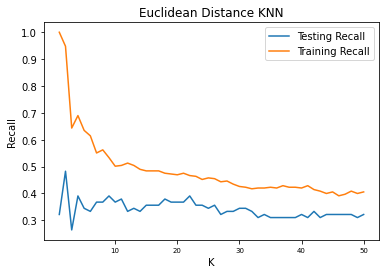

In [19]:
x_range = range(start_k, end_k, step)
x_tick_range = range(10, end_k, 10)


plt.plot(x_range, euc_test_rec, label="Testing Recall")
plt.plot(x_range, euc_train_rec, label="Training Recall")
plt.title("Euclidean Distance KNN")
plt.xlabel("K")
plt.ylabel("Recall")
plt.xticks(x_tick_range, fontsize=7)
plt.legend()
plt.savefig('euc_knn_recall.png')
plt.show()

Plot Accuracy values

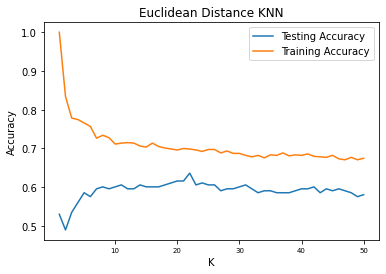

In [20]:
x_range = range(start_k, end_k, step)
x_tick_range = range(10, end_k, 10)

plt.plot(x_range, euc_test_acc, label="Testing Accuracy")
plt.plot(x_range, euc_train_acc, label="Training Accuracy")
plt.title("Euclidean Distance KNN")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.xticks(x_tick_range, fontsize=7)
plt.legend()
plt.savefig('euc_knn_acc.png')
plt.show()

Lets figure out what "K" gave us the best recall score.

In [21]:
d = {}
for i in range(len(euc_train_acc)):
    d[i+1] = (euc_test_rec[i], euc_train_rec[i], euc_test_acc[i], euc_train_acc[i], euc_crs[i])
sorted_keys = sorted(d.keys(), key=lambda x: d[x][0], reverse=True)
print("Best k values, sorted by testing recalls...")
for i, key in enumerate(sorted_keys):
    print(f"K: {key}, Testing Recall: {d[key][0]}, Training Recall: {d[key][1]} Testing Accuracy: {d[key][2]}, Training Accuracy: {d[key][3]}")
    if i > 10:
        break

Best k values, sorted by testing recalls...
K: 2, Testing Recall: 0.4827586206896552, Training Recall: 0.9478260869565217 Testing Accuracy: 0.4898989898989899, Training Accuracy: 0.8341772151898734
K: 4, Testing Recall: 0.39080459770114945, Training Recall: 0.6898550724637681 Testing Accuracy: 0.5606060606060606, Training Accuracy: 0.7746835443037975
K: 9, Testing Recall: 0.39080459770114945, Training Recall: 0.5333333333333333 Testing Accuracy: 0.5959595959595959, Training Accuracy: 0.7278481012658228
K: 22, Testing Recall: 0.39080459770114945, Training Recall: 0.46666666666666656 Testing Accuracy: 0.6363636363636364, Training Accuracy: 0.6987341772151898
K: 11, Testing Recall: 0.3793103448275862, Training Recall: 0.5043478260869565 Testing Accuracy: 0.6060606060606061, Training Accuracy: 0.7139240506329114
K: 18, Testing Recall: 0.3793103448275862, Training Recall: 0.4753623188405797 Testing Accuracy: 0.6060606060606061, Training Accuracy: 0.7012658227848101
K: 7, Testing Recall: 0.3

Print classification report of the best model to see breakdown

In [22]:
print(d[sorted_keys[0]][4])

              precision    recall  f1-score   support

   Aspergers       0.17      0.26      0.21        19
      Autism       0.44      0.54      0.48        68
    Controls       0.65      0.50      0.56       111

    accuracy                           0.49       198
   macro avg       0.42      0.43      0.42       198
weighted avg       0.53      0.49      0.50       198



#### DTW Distance Metric

In [23]:
dtw_train_dist, dtw_test_dist = precompute_distance_vectors(X_train, X_test, dtw_distance)

Calculated 0 of 198 distances
Calculated 50 of 198 distances
Calculated 100 of 198 distances
Calculated 150 of 198 distances
Calculated 0 of 790 distances
Calculated 50 of 790 distances
Calculated 100 of 790 distances
Calculated 150 of 790 distances
Calculated 200 of 790 distances
Calculated 250 of 790 distances
Calculated 300 of 790 distances
Calculated 350 of 790 distances
Calculated 400 of 790 distances
Calculated 450 of 790 distances
Calculated 500 of 790 distances
Calculated 550 of 790 distances
Calculated 600 of 790 distances
Calculated 650 of 790 distances
Calculated 700 of 790 distances
Calculated 750 of 790 distances


In [24]:
dtw_train_acc, dtw_test_acc, dtw_train_rec, dtw_test_rec, dtw_crs = run_knn(dtw_train_dist, dtw_test_dist, start_k, end_k, step)

K = 1
K = 2
K = 3
K = 4
K = 5
K = 6
K = 7
K = 8
K = 9
K = 10
K = 11
K = 12
K = 13
K = 14
K = 15
K = 16
K = 17
K = 18
K = 19
K = 20
K = 21
K = 22
K = 23
K = 24
K = 25
K = 26
K = 27
K = 28
K = 29
K = 30
K = 31
K = 32
K = 33
K = 34
K = 35
K = 36
K = 37
K = 38
K = 39
K = 40
K = 41
K = 42
K = 43
K = 44
K = 45
K = 46
K = 47
K = 48
K = 49
K = 50


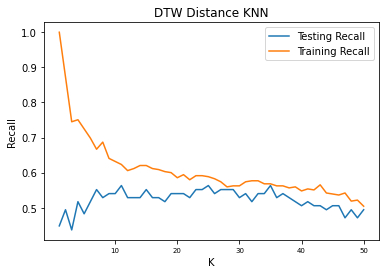

In [25]:
x_range = range(start_k, end_k, step)
x_tick_range = range(10, end_k, 10)

plt.plot(x_range, dtw_test_rec, label="Testing Recall")
plt.plot(x_range, dtw_train_rec, label="Training Recall")
plt.title("DTW Distance KNN")
plt.xlabel("K")
plt.ylabel("Recall")
plt.xticks(x_tick_range, fontsize=7)
plt.legend()
plt.savefig('dtw_knn_recall.png')
plt.show()

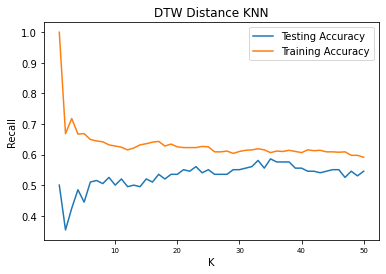

In [26]:
x_range = range(start_k, end_k, step)
x_tick_range = range(10, end_k, 10)


plt.plot(x_range, dtw_test_acc, label="Testing Accuracy")
plt.plot(x_range, dtw_train_acc, label="Training Accuracy")
plt.title("DTW Distance KNN")
plt.xlabel("K")
plt.ylabel("Recall")
plt.xticks(x_tick_range, fontsize=7)
plt.legend()
plt.savefig('dtw_knn_acc.png')
plt.show()

In [27]:
d = {}
for i in range(len(dtw_train_acc)):
    d[i+1] = (dtw_test_rec[i], dtw_train_rec[i], dtw_test_acc[i], dtw_train_rec[i], dtw_crs[i])
sorted_keys = sorted(d.keys(), key=lambda x: d[x][0], reverse=True)
print("Best k values, sorted by testing recalls...")
for i, key in enumerate(sorted_keys):
    print(f"K: {key}, Testing Recall: {d[key][0]}, Training Recall: {d[key][1]} Testing Accuracy: {d[key][2]}, Training Accuracy: {d[key][3]}")
    if i > 10:
        break

Best k values, sorted by testing recalls...
K: 11, Testing Recall: 0.5632183908045977, Training Recall: 0.6231884057971014 Testing Accuracy: 0.5202020202020202, Training Accuracy: 0.6231884057971014
K: 25, Testing Recall: 0.5632183908045977, Training Recall: 0.5884057971014492 Testing Accuracy: 0.5505050505050505, Training Accuracy: 0.5884057971014492
K: 35, Testing Recall: 0.5632183908045977, Training Recall: 0.5681159420289855 Testing Accuracy: 0.5858585858585859, Training Accuracy: 0.5681159420289855
K: 7, Testing Recall: 0.5517241379310345, Training Recall: 0.6666666666666666 Testing Accuracy: 0.5151515151515151, Training Accuracy: 0.6666666666666666
K: 15, Testing Recall: 0.5517241379310345, Training Recall: 0.6202898550724638 Testing Accuracy: 0.5202020202020202, Training Accuracy: 0.6202898550724638
K: 23, Testing Recall: 0.5517241379310345, Training Recall: 0.591304347826087 Testing Accuracy: 0.5606060606060606, Training Accuracy: 0.591304347826087
K: 24, Testing Recall: 0.5517

Print classification report of best model see breakdown

In [28]:
print(d[sorted_keys[0]][4])

              precision    recall  f1-score   support

   Aspergers       0.00      0.00      0.00        19
      Autism       0.42      0.72      0.53        68
    Controls       0.68      0.49      0.57       111

    accuracy                           0.52       198
   macro avg       0.36      0.40      0.36       198
weighted avg       0.52      0.52      0.50       198



## Differential Distance Based Classifiers

### Complexity Invariant Distance

For this, I'm going to implement Complexity Invariant Distance (CID) and then use the results on a KNN classifier (source: https://www.researchgate.net/publication/220906685_A_Complexity-Invariant_Distance_Measure_for_Time_Series)

In [29]:
def cid_dist(q, c):
    ce_q = np.sqrt(np.sum(np.diff(q) ** 2))
    ce_c = np.sqrt(np.sum(np.diff(c) ** 2))
    d = np.sqrt(np.sum((q - c) ** 2)) * (np.maximum(ce_q, ce_c) / np.minimum(ce_q, ce_c))
    return d

In [30]:
cid_train_dist, cid_test_dist = precompute_distance_vectors(X_train, X_test, cid_dist)

Calculated 0 of 198 distances
Calculated 50 of 198 distances
Calculated 100 of 198 distances
Calculated 150 of 198 distances
Calculated 0 of 790 distances
Calculated 50 of 790 distances
Calculated 100 of 790 distances
Calculated 150 of 790 distances
Calculated 200 of 790 distances
Calculated 250 of 790 distances
Calculated 300 of 790 distances
Calculated 350 of 790 distances
Calculated 400 of 790 distances
Calculated 450 of 790 distances
Calculated 500 of 790 distances
Calculated 550 of 790 distances
Calculated 600 of 790 distances
Calculated 650 of 790 distances
Calculated 700 of 790 distances
Calculated 750 of 790 distances


In [31]:
cid_train_acc, cid_test_acc, cid_train_rec, cid_test_rec, cid_crs = run_knn(cid_train_dist, cid_test_dist, start_k, end_k, step)

K = 1
K = 2
K = 3
K = 4
K = 5
K = 6
K = 7
K = 8
K = 9
K = 10
K = 11
K = 12
K = 13
K = 14
K = 15
K = 16
K = 17
K = 18
K = 19
K = 20
K = 21
K = 22
K = 23
K = 24
K = 25
K = 26
K = 27
K = 28
K = 29
K = 30
K = 31
K = 32
K = 33
K = 34
K = 35
K = 36
K = 37
K = 38
K = 39
K = 40
K = 41
K = 42
K = 43
K = 44
K = 45
K = 46
K = 47
K = 48
K = 49
K = 50


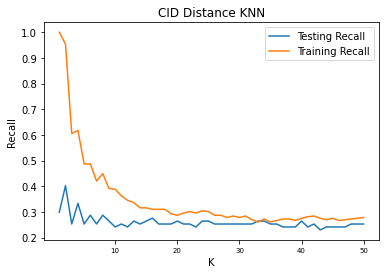

In [32]:
x_range = range(start_k, end_k, step)
x_tick_range = range(10, end_k, 10)


plt.plot(x_range, cid_test_rec, label="Testing Recall")
plt.plot(x_range, cid_train_rec, label="Training Recall")
plt.title("CID Distance KNN")
plt.xlabel("K")
plt.ylabel("Recall")
plt.xticks(x_tick_range, fontsize=7)
plt.legend()
plt.savefig('cid_knn_recall.png')
plt.show()

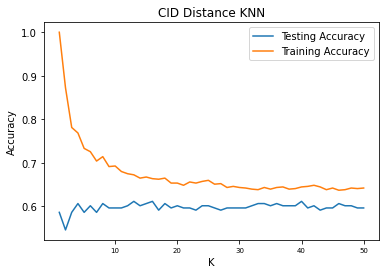

In [33]:
x_range = range(start_k, end_k, step)
x_tick_range = range(10, end_k, 10)

plt.plot(x_range, cid_test_acc, label="Testing Accuracy")
plt.plot(x_range, cid_train_acc, label="Training Accuracy")
plt.title("CID Distance KNN")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.xticks(x_tick_range, fontsize=7)
plt.legend()
plt.savefig('cid_knn_acc.png')
plt.show()

In [34]:
d = {}
for i in range(len(cid_train_acc)):
    d[i+1] = (cid_test_rec[i], cid_train_rec[i], cid_test_acc[i], cid_train_acc[i], cid_crs[i])
sorted_keys = sorted(d.keys(), key=lambda x: d[x][0], reverse=True)
print("Best k values, sorted by testing recalls...")
for i, key in enumerate(sorted_keys):
    print(f"K: {key}, Testing Recall: {d[key][0]}, Training Recall: {d[key][1]} Testing Accuracy: {d[key][2]}, Training Accuracy: {d[key][3]}")
    if i > 10:
        break

Best k values, sorted by testing recalls...
K: 2, Testing Recall: 0.40229885057471265, Training Recall: 0.9536231884057971 Testing Accuracy: 0.5454545454545454, Training Accuracy: 0.8721518987341772
K: 4, Testing Recall: 0.3333333333333333, Training Recall: 0.6173913043478261 Testing Accuracy: 0.6060606060606061, Training Accuracy: 0.7683544303797468
K: 1, Testing Recall: 0.2988505747126437, Training Recall: 1.0 Testing Accuracy: 0.5858585858585859, Training Accuracy: 1.0
K: 6, Testing Recall: 0.28735632183908044, Training Recall: 0.48695652173913045 Testing Accuracy: 0.601010101010101, Training Accuracy: 0.7253164556962025
K: 8, Testing Recall: 0.28735632183908044, Training Recall: 0.4492753623188406 Testing Accuracy: 0.6060606060606061, Training Accuracy: 0.7139240506329114
K: 16, Testing Recall: 0.27586206896551724, Training Recall: 0.3101449275362319 Testing Accuracy: 0.6111111111111112, Training Accuracy: 0.6632911392405063
K: 9, Testing Recall: 0.26436781609195403, Training Recal

Print classification report of best model see breakdown

In [35]:
print(d[sorted_keys[0]][4])

              precision    recall  f1-score   support

   Aspergers       0.25      0.21      0.23        19
      Autism       0.44      0.46      0.45        68
    Controls       0.65      0.66      0.65       111

    accuracy                           0.55       198
   macro avg       0.45      0.44      0.44       198
weighted avg       0.54      0.55      0.54       198



## Interval Based Classifiers

Convert the numpy array to a univariate time series readable by sktime

In [36]:
def to_sktime(X):
    l = []
    X = X.values.astype(float)
    for row in X:
        l.append(pd.Series(row))
    X_new = pd.DataFrame()
    X_new['dim_0'] = l
    return X_new

### Time Series Forest

In [37]:
X_train_sk = to_sktime(X_train)
X_test_sk = to_sktime(X_test)
start_n, end_n, step = 10, 201, 10

In [38]:
training_accuracies = []
testing_accuracies = []
training_recalls = []
testing_recalls = []
tsf_crs = []
for i in range(start_n, end_n, step):
    print(f"Training with {i} estimators")
    classifier = TimeSeriesForestClassifier(n_estimators=i)
    classifier.fit(X_train_sk, y_train)

    train_pred = classifier.predict(X_train_sk)
    train_acc = accuracy_score(y_train, train_pred)
    training_accuracies.append(train_acc)
    train_rec = recall_score(y_train, train_pred, labels=['Aspergers', 'Autism'], average='weighted')
    training_recalls.append(train_rec)

    test_pred = classifier.predict(X_test_sk)
    test_acc = accuracy_score(y_test, test_pred)
    testing_accuracies.append(test_acc)
    test_rec = recall_score(y_test, test_pred, labels=['Aspergers', 'Autism'], average='weighted')
    testing_recalls.append(test_rec)

    cr = classification_report(y_test, test_pred)
    tsf_crs.append(cr)


Training with 10 estimators
Training with 20 estimators
Training with 30 estimators
Training with 40 estimators
Training with 50 estimators
Training with 60 estimators
Training with 70 estimators
Training with 80 estimators
Training with 90 estimators
Training with 100 estimators
Training with 110 estimators
Training with 120 estimators
Training with 130 estimators
Training with 140 estimators
Training with 150 estimators
Training with 160 estimators
Training with 170 estimators
Training with 180 estimators
Training with 190 estimators
Training with 200 estimators


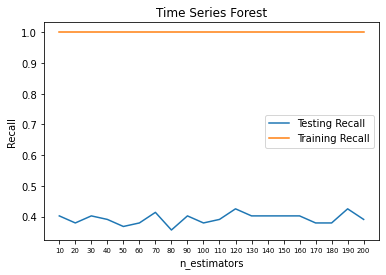

In [39]:
x_tick_range = range(start_n, end_n, step)

plt.plot(x_tick_range, testing_recalls, label="Testing Recall")
plt.plot(x_tick_range, training_recalls, label="Training Recall")
plt.title("Time Series Forest")
plt.xlabel("n_estimators")
plt.ylabel("Recall")
plt.xticks(x_tick_range, fontsize=7)
plt.legend()
plt.savefig('tsf_recall.png')
plt.show()

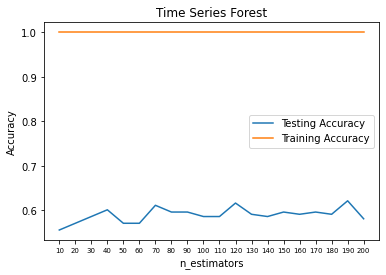

In [40]:
x_tick_range = range(start_n, end_n, step)

plt.plot(x_tick_range, testing_accuracies, label="Testing Accuracy")
plt.plot(x_tick_range, training_accuracies, label="Training Accuracy")
plt.title("Time Series Forest")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.xticks(x_tick_range, fontsize=7)
plt.legend()
plt.savefig('tsf_acc.png')
plt.show()

In [41]:
d = {}
for i in range(len(training_accuracies)):
    d[(i+1)*10] = (testing_recalls[i], training_recalls[i], testing_accuracies[i], training_accuracies[i], tsf_crs[i])
sorted_keys = sorted(d.keys(), key=lambda x: d[x][0], reverse=True)
print("Best k values, sorted by testing recalls...")
for i, key in enumerate(sorted_keys):
    print(f"N: {key}, Testing Recall: {d[key][0]}, Training Recall: {d[key][1]} Testing Accuracy: {d[key][2]}, Training Accuracy: {d[key][3]}")
    if i > 10:
        break

Best k values, sorted by testing recalls...
N: 120, Testing Recall: 0.42528735632183906, Training Recall: 1.0 Testing Accuracy: 0.6161616161616161, Training Accuracy: 1.0
N: 190, Testing Recall: 0.42528735632183906, Training Recall: 1.0 Testing Accuracy: 0.6212121212121212, Training Accuracy: 1.0
N: 70, Testing Recall: 0.41379310344827586, Training Recall: 1.0 Testing Accuracy: 0.6111111111111112, Training Accuracy: 1.0
N: 10, Testing Recall: 0.40229885057471265, Training Recall: 1.0 Testing Accuracy: 0.5555555555555556, Training Accuracy: 1.0
N: 30, Testing Recall: 0.40229885057471265, Training Recall: 1.0 Testing Accuracy: 0.5858585858585859, Training Accuracy: 1.0
N: 90, Testing Recall: 0.40229885057471265, Training Recall: 1.0 Testing Accuracy: 0.5959595959595959, Training Accuracy: 1.0
N: 130, Testing Recall: 0.40229885057471265, Training Recall: 1.0 Testing Accuracy: 0.5909090909090909, Training Accuracy: 1.0
N: 140, Testing Recall: 0.40229885057471265, Training Recall: 1.0 Testi

Print classification report of best model to see total breakdown

In [42]:
print(d[sorted_keys[0]][4])

              precision    recall  f1-score   support

   Aspergers       0.00      0.00      0.00        19
      Autism       0.53      0.54      0.54        68
    Controls       0.66      0.77      0.71       111

    accuracy                           0.62       198
   macro avg       0.40      0.44      0.42       198
weighted avg       0.55      0.62      0.58       198



## Dictionary Based



### Bag Of Patterns

In [43]:
window_sizes = [i for i in range(25, 301, 25)]
word_sizes = [2, 3, 4, 5]

bop_results = {}
bop_graphs = {}
for window in window_sizes:
    for word_size in word_sizes:
        if word_size < window:
            print(f"Word Size: {word_size}, Window Size: {window}")
            bop = BagOfPatterns(
                window_size=window,
                word_size=word_size,
                n_bins=2,
                numerosity_reduction=False,
                sparse=False
            )

            X_train_bop = bop.fit_transform(X_train, y_train)
            X_test_bop = bop.fit_transform(X_test, y_test)

            knn = KNeighborsClassifier(n_neighbors=1)
            knn.fit(X_train_bop, y_train)

            test_pred = knn.predict(X_test_bop)
            test_rec = recall_score(y_test, test_pred, labels=['Aspergers', 'Autism'], average='weighted')
            test_acc = accuracy_score(y_test, test_pred)

            train_pred = knn.predict(X_train_bop)
            train_rec = recall_score(y_train, train_pred, labels=['Aspergers', 'Autism'], average='weighted')
            train_acc = accuracy_score(y_train, train_pred)

            cr = classification_report(y_test, test_pred)

            key = (window, word_size)
            value = (test_rec, train_rec, test_acc, train_acc, cr)
            bop_results[key] = value

            if word_size not in bop_graphs:
                bop_graphs[word_size] = []
            bop_graphs[word_size].append(value)

Word Size: 2, Window Size: 25


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 3, Window Size: 25


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 4, Window Size: 25


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 5, Window Size: 25


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 2, Window Size: 50


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 3, Window Size: 50


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 4, Window Size: 50


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 5, Window Size: 50


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 2, Window Size: 75


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 3, Window Size: 75


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 4, Window Size: 75


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 5, Window Size: 75


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 2, Window Size: 100


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 3, Window Size: 100


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 4, Window Size: 100


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 5, Window Size: 100


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 2, Window Size: 125


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 3, Window Size: 125


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 4, Window Size: 125


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 5, Window Size: 125


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 2, Window Size: 150


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 3, Window Size: 150


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 4, Window Size: 150


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 5, Window Size: 150


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 2, Window Size: 175


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 3, Window Size: 175


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 4, Window Size: 175


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 5, Window Size: 175


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 2, Window Size: 200


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 3, Window Size: 200


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 4, Window Size: 200


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 5, Window Size: 200


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 2, Window Size: 225


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 3, Window Size: 225


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 4, Window Size: 225


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 5, Window Size: 225


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 2, Window Size: 250


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 3, Window Size: 250


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 4, Window Size: 250


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 5, Window Size: 250


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 2, Window Size: 275


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 3, Window Size: 275


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 4, Window Size: 275


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 5, Window Size: 275


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 2, Window Size: 300


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 3, Window Size: 300


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 4, Window Size: 300


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


Word Size: 5, Window Size: 300


/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyts/bag_of_words/bow.py:246: FutureWarning: BagOfWords has been reworked in 0.11 in order to match its definition in the literature. To get the old BagOfWords, use pyts.bag_of_words.WordExtractor instead.
  "instead.", FutureWarning)


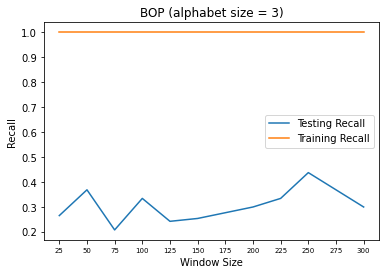

In [44]:
x_tick_range = range(25, 301, 25)

testing_recalls = [x[0] for x in bop_graphs[3]]
training_recalls = [x[1] for x in bop_graphs[3]]

plt.plot(x_tick_range, testing_recalls, label="Testing Recall")
plt.plot(x_tick_range, training_recalls, label="Training Recall")
plt.title("BOP (alphabet size = 3)")
plt.xlabel("Window Size")
plt.ylabel("Recall")
plt.xticks(x_tick_range, fontsize=7)
plt.legend()
plt.savefig('bop_recall.png')
plt.show()

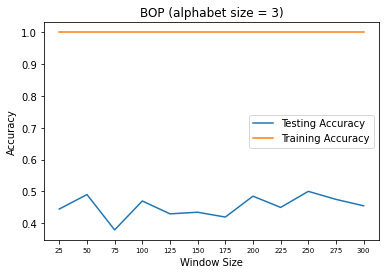

In [45]:
x_tick_range = range(25, 301, 25)

testing_accuracies = [x[2] for x in bop_graphs[3]]
training_accuracies = [x[3] for x in bop_graphs[3]]

plt.plot(x_tick_range, testing_accuracies, label="Testing Accuracy")
plt.plot(x_tick_range, training_accuracies, label="Training Accuracy")
plt.title("BOP (alphabet size = 3)")
plt.xlabel("Window Size")
plt.ylabel("Accuracy")
plt.xticks(x_tick_range, fontsize=7)
plt.legend()
plt.savefig('bop_acc.png')
plt.show()

In [46]:
sorted_keys = sorted(bop_results.keys(), key=lambda x: bop_results[x][0], reverse=True)
print("Best hyper-parameters, sorted by testing recall...")
for i, key in enumerate(sorted_keys):
    print(f"Window Size: {key[0]}, Word Size: {key[1]} Testing Recall: {bop_results[key][0]} Training Recall: {bop_results[key][1]} Testing Accuracy: {bop_results[key][2]}, Training Accuracy: {bop_results[key][3]}")
    if i > 10:
        break

Best hyper-parameters, sorted by testing recall...
Window Size: 250, Word Size: 3 Testing Recall: 0.4367816091954023 Training Recall: 1.0 Testing Accuracy: 0.5, Training Accuracy: 1.0
Window Size: 300, Word Size: 5 Testing Recall: 0.3793103448275862 Training Recall: 1.0 Testing Accuracy: 0.4696969696969697, Training Accuracy: 1.0
Window Size: 50, Word Size: 3 Testing Recall: 0.367816091954023 Training Recall: 1.0 Testing Accuracy: 0.4898989898989899, Training Accuracy: 1.0
Window Size: 275, Word Size: 3 Testing Recall: 0.367816091954023 Training Recall: 1.0 Testing Accuracy: 0.47474747474747475, Training Accuracy: 1.0
Window Size: 275, Word Size: 5 Testing Recall: 0.367816091954023 Training Recall: 1.0 Testing Accuracy: 0.46464646464646464, Training Accuracy: 1.0
Window Size: 100, Word Size: 4 Testing Recall: 0.3563218390804598 Training Recall: 1.0 Testing Accuracy: 0.4444444444444444, Training Accuracy: 1.0
Window Size: 175, Word Size: 2 Testing Recall: 0.3563218390804598 Training Rec

Print classification report of best model see breakdown

In [47]:
print(bop_results[sorted_keys[0]][4])

              precision    recall  f1-score   support

   Aspergers       0.20      0.16      0.18        19
      Autism       0.42      0.51      0.46        68
    Controls       0.62      0.55      0.58       111

    accuracy                           0.50       198
   macro avg       0.41      0.41      0.41       198
weighted avg       0.51      0.50      0.50       198



## Deep Learning Methods

In [48]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train.values)
training_labels = le.transform(y_train.values)
testing_labels = le.transform(y_test.values)
training_features = X_train.values.astype(float)
testing_features = X_test.values.astype(float)

In [49]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class AutismDataset(Dataset):
    def __init__(self, train_features, train_labels):
        super().__init__()
        self.train_features = train_features
        self.train_labels = train_labels

    def __len__(self):
        return len(self.train_features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.train_features[idx], self.train_labels[idx])

### Artifical Neural Network (ANN)

In [50]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim=3):
        super().__init__()
        self.network = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.Linear(64, output_dim)
        )

    def forward(self, xb):
        xb = self.network(xb)
        return xb


In [51]:
criterion = nn.CrossEntropyLoss()
batch_size = 8
lr = 0.0001

labels_unique, counts = np.unique(training_labels, return_counts=True)
class_weights = [sum(counts) / c for c in counts]
example_weights = [class_weights[e] for e in training_labels]
sampler = WeightedRandomSampler(example_weights, len(training_labels))

Epoch: 0 Train acc: 35.69620253164557 Testing acc: 38.38383838383838
Epoch: 10 Train acc: 55.822784810126585 Testing acc: 51.01010101010101
Epoch: 20 Train acc: 64.0506329113924 Testing acc: 52.02020202020202
Epoch: 30 Train acc: 68.60759493670886 Testing acc: 52.02020202020202
Epoch: 40 Train acc: 73.16455696202532 Testing acc: 52.525252525252526
Epoch: 50 Train acc: 73.67088607594937 Testing acc: 54.54545454545455
Epoch: 60 Train acc: 78.35443037974683 Testing acc: 55.55555555555556
Epoch: 70 Train acc: 81.64556962025317 Testing acc: 55.55555555555556
Epoch: 80 Train acc: 82.15189873417721 Testing acc: 56.06060606060606
Epoch: 90 Train acc: 80.37974683544304 Testing acc: 59.09090909090909
Epoch: 100 Train acc: 82.53164556962025 Testing acc: 58.08080808080808
Epoch: 110 Train acc: 83.92405063291139 Testing acc: 59.09090909090909
Epoch: 120 Train acc: 86.9620253164557 Testing acc: 57.57575757575758
Epoch: 130 Train acc: 85.44303797468355 Testing acc: 57.57575757575758
Epoch: 140 Train 

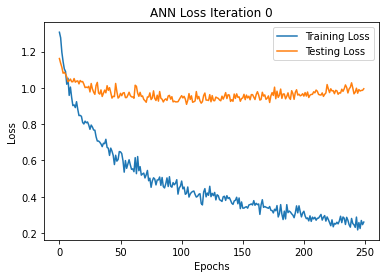

Test accuracy iteration 0: 59.09090909090909%
Test recall iteration 0: 56.32183908045977%


Epoch: 0 Train acc: 34.43037974683544 Testing acc: 42.42424242424242
Epoch: 10 Train acc: 56.075949367088604 Testing acc: 52.525252525252526
Epoch: 20 Train acc: 67.59493670886076 Testing acc: 52.525252525252526
Epoch: 30 Train acc: 69.24050632911393 Testing acc: 56.56565656565657
Epoch: 40 Train acc: 73.29113924050633 Testing acc: 57.57575757575758
Epoch: 50 Train acc: 73.92405063291139 Testing acc: 56.56565656565657
Epoch: 60 Train acc: 79.36708860759494 Testing acc: 56.56565656565657
Epoch: 70 Train acc: 79.87341772151899 Testing acc: 61.111111111111114
Epoch: 80 Train acc: 79.87341772151899 Testing acc: 57.07070707070707
Epoch: 90 Train acc: 80.63291139240506 Testing acc: 57.57575757575758
Epoch: 100 Train acc: 82.27848101265823 Testing acc: 61.111111111111114
Epoch: 110 Train acc: 84.55696202531645 Testing acc: 62.121212121212125
Epoch: 120 Train acc: 85.56962025316456 Testing acc: 60.10101

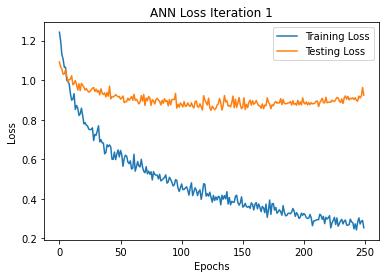

Test accuracy iteration 1: 62.121212121212125%
Test recall iteration 1: 60.91954022988506%


Epoch: 0 Train acc: 33.924050632911396 Testing acc: 41.91919191919192
Epoch: 10 Train acc: 54.30379746835443 Testing acc: 52.02020202020202
Epoch: 20 Train acc: 64.43037974683544 Testing acc: 52.525252525252526
Epoch: 30 Train acc: 68.60759493670886 Testing acc: 57.57575757575758
Epoch: 40 Train acc: 74.55696202531645 Testing acc: 55.05050505050505
Epoch: 50 Train acc: 74.0506329113924 Testing acc: 54.04040404040404
Epoch: 60 Train acc: 77.84810126582279 Testing acc: 55.05050505050505
Epoch: 70 Train acc: 80.37974683544304 Testing acc: 58.08080808080808
Epoch: 80 Train acc: 80.25316455696202 Testing acc: 57.57575757575758
Epoch: 90 Train acc: 78.86075949367088 Testing acc: 57.07070707070707
Epoch: 100 Train acc: 82.9113924050633 Testing acc: 57.57575757575758
Epoch: 110 Train acc: 84.0506329113924 Testing acc: 58.58585858585859
Epoch: 120 Train acc: 84.17721518987342 Testing acc: 60.10101010101

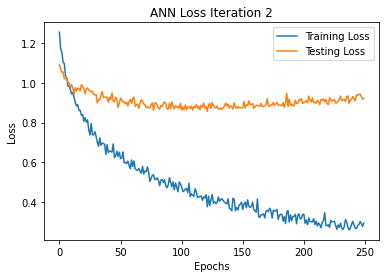

Test accuracy iteration 2: 57.57575757575758%
Test recall iteration 2: 55.172413793103445%


Epoch: 0 Train acc: 31.89873417721519 Testing acc: 37.37373737373738
Epoch: 10 Train acc: 53.54430379746835 Testing acc: 48.484848484848484
Epoch: 20 Train acc: 64.9367088607595 Testing acc: 52.02020202020202
Epoch: 30 Train acc: 66.70886075949367 Testing acc: 50.0
Epoch: 40 Train acc: 70.12658227848101 Testing acc: 48.484848484848484
Epoch: 50 Train acc: 75.44303797468355 Testing acc: 50.0
Epoch: 60 Train acc: 74.55696202531645 Testing acc: 53.03030303030303
Epoch: 70 Train acc: 77.0886075949367 Testing acc: 56.06060606060606
Epoch: 80 Train acc: 80.25316455696202 Testing acc: 56.56565656565657
Epoch: 90 Train acc: 83.79746835443038 Testing acc: 53.535353535353536
Epoch: 100 Train acc: 82.65822784810126 Testing acc: 57.57575757575758
Epoch: 110 Train acc: 79.49367088607595 Testing acc: 52.02020202020202
Epoch: 120 Train acc: 85.31645569620254 Testing acc: 56.06060606060606
Epoch: 130 Train acc

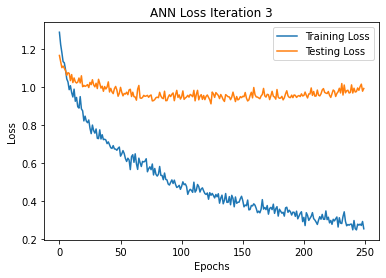

Test accuracy iteration 3: 57.57575757575758%
Test recall iteration 3: 55.172413793103445%


Epoch: 0 Train acc: 36.32911392405063 Testing acc: 38.888888888888886
Epoch: 10 Train acc: 52.53164556962025 Testing acc: 45.45454545454545
Epoch: 20 Train acc: 62.40506329113924 Testing acc: 48.98989898989899
Epoch: 30 Train acc: 69.87341772151899 Testing acc: 46.96969696969697
Epoch: 40 Train acc: 77.21518987341773 Testing acc: 52.525252525252526
Epoch: 50 Train acc: 74.30379746835443 Testing acc: 51.515151515151516
Epoch: 60 Train acc: 79.11392405063292 Testing acc: 54.04040404040404
Epoch: 70 Train acc: 80.0 Testing acc: 54.54545454545455
Epoch: 80 Train acc: 80.63291139240506 Testing acc: 56.56565656565657
Epoch: 90 Train acc: 82.9113924050633 Testing acc: 54.54545454545455
Epoch: 100 Train acc: 84.68354430379746 Testing acc: 56.56565656565657
Epoch: 110 Train acc: 85.0632911392405 Testing acc: 56.06060606060606
Epoch: 120 Train acc: 84.81012658227849 Testing acc: 59.5959595959596
Epoch: 1

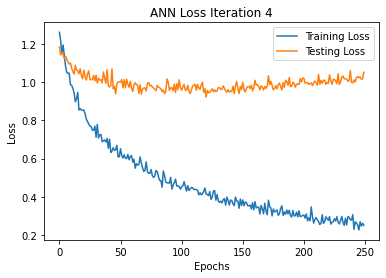

Test accuracy iteration 4: 56.56565656565657%
Test recall iteration 4: 56.32183908045977%


Epoch: 0 Train acc: 29.11392405063291 Testing acc: 38.38383838383838
Epoch: 10 Train acc: 49.36708860759494 Testing acc: 48.98989898989899
Epoch: 20 Train acc: 60.50632911392405 Testing acc: 52.525252525252526
Epoch: 30 Train acc: 65.9493670886076 Testing acc: 56.06060606060606
Epoch: 40 Train acc: 72.65822784810126 Testing acc: 57.57575757575758
Epoch: 50 Train acc: 72.9113924050633 Testing acc: 58.58585858585859
Epoch: 60 Train acc: 75.0632911392405 Testing acc: 57.57575757575758
Epoch: 70 Train acc: 79.62025316455696 Testing acc: 58.08080808080808
Epoch: 80 Train acc: 81.51898734177215 Testing acc: 61.111111111111114
Epoch: 90 Train acc: 83.67088607594937 Testing acc: 58.58585858585859
Epoch: 100 Train acc: 82.40506329113924 Testing acc: 58.58585858585859
Epoch: 110 Train acc: 86.20253164556962 Testing acc: 61.111111111111114
Epoch: 120 Train acc: 85.44303797468355 Testing acc: 60.10101010101

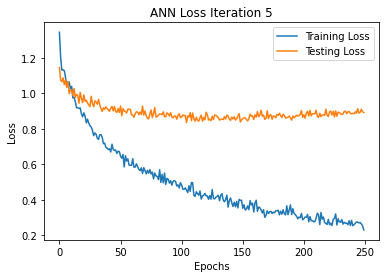

Test accuracy iteration 5: 63.63636363636363%
Test recall iteration 5: 59.77011494252874%


Epoch: 0 Train acc: 34.050632911392405 Testing acc: 36.86868686868687
Epoch: 10 Train acc: 53.924050632911396 Testing acc: 51.515151515151516
Epoch: 20 Train acc: 63.164556962025316 Testing acc: 49.494949494949495
Epoch: 30 Train acc: 70.88607594936708 Testing acc: 51.01010101010101
Epoch: 40 Train acc: 72.65822784810126 Testing acc: 51.01010101010101
Epoch: 50 Train acc: 76.70886075949367 Testing acc: 53.03030303030303
Epoch: 60 Train acc: 78.60759493670886 Testing acc: 54.54545454545455
Epoch: 70 Train acc: 78.60759493670886 Testing acc: 55.05050505050505
Epoch: 80 Train acc: 81.64556962025317 Testing acc: 56.56565656565657
Epoch: 90 Train acc: 84.9367088607595 Testing acc: 56.06060606060606
Epoch: 100 Train acc: 81.0126582278481 Testing acc: 58.58585858585859
Epoch: 110 Train acc: 84.0506329113924 Testing acc: 58.08080808080808
Epoch: 120 Train acc: 84.0506329113924 Testing acc: 54.5454545454

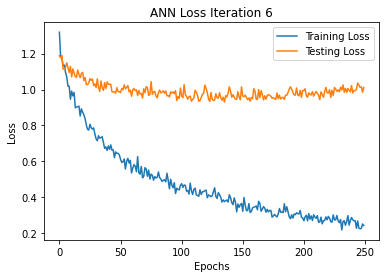

Test accuracy iteration 6: 58.08080808080808%
Test recall iteration 6: 60.91954022988506%


Epoch: 0 Train acc: 36.32911392405063 Testing acc: 35.35353535353536
Epoch: 10 Train acc: 55.063291139240505 Testing acc: 47.474747474747474
Epoch: 20 Train acc: 63.67088607594937 Testing acc: 44.94949494949495
Epoch: 30 Train acc: 67.9746835443038 Testing acc: 50.0
Epoch: 40 Train acc: 72.40506329113924 Testing acc: 50.0
Epoch: 50 Train acc: 76.45569620253164 Testing acc: 52.525252525252526
Epoch: 60 Train acc: 78.35443037974683 Testing acc: 52.525252525252526
Epoch: 70 Train acc: 79.11392405063292 Testing acc: 55.55555555555556
Epoch: 80 Train acc: 82.15189873417721 Testing acc: 53.03030303030303
Epoch: 90 Train acc: 81.64556962025317 Testing acc: 54.54545454545455
Epoch: 100 Train acc: 82.15189873417721 Testing acc: 57.07070707070707
Epoch: 110 Train acc: 84.30379746835443 Testing acc: 56.06060606060606
Epoch: 120 Train acc: 83.79746835443038 Testing acc: 57.57575757575758
Epoch: 130 Train ac

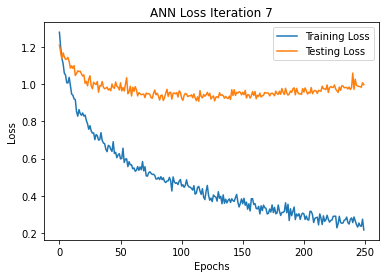

Test accuracy iteration 7: 57.57575757575758%
Test recall iteration 7: 56.32183908045977%


Epoch: 0 Train acc: 30.632911392405063 Testing acc: 41.91919191919192
Epoch: 10 Train acc: 53.29113924050633 Testing acc: 51.01010101010101
Epoch: 20 Train acc: 62.78481012658228 Testing acc: 54.04040404040404
Epoch: 30 Train acc: 65.56962025316456 Testing acc: 53.03030303030303
Epoch: 40 Train acc: 73.29113924050633 Testing acc: 56.56565656565657
Epoch: 50 Train acc: 74.81012658227849 Testing acc: 57.57575757575758
Epoch: 60 Train acc: 78.35443037974683 Testing acc: 55.05050505050505
Epoch: 70 Train acc: 80.12658227848101 Testing acc: 58.58585858585859
Epoch: 80 Train acc: 82.53164556962025 Testing acc: 58.08080808080808
Epoch: 90 Train acc: 84.0506329113924 Testing acc: 58.08080808080808
Epoch: 100 Train acc: 84.55696202531645 Testing acc: 58.58585858585859
Epoch: 110 Train acc: 82.65822784810126 Testing acc: 57.07070707070707
Epoch: 120 Train acc: 85.56962025316456 Testing acc: 59.09090909090

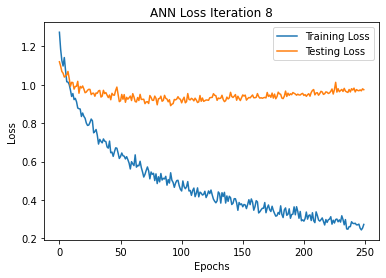

Test accuracy iteration 8: 59.09090909090909%
Test recall iteration 8: 50.57471264367817%


Epoch: 0 Train acc: 34.43037974683544 Testing acc: 37.37373737373738
Epoch: 10 Train acc: 53.29113924050633 Testing acc: 46.96969696969697
Epoch: 20 Train acc: 62.40506329113924 Testing acc: 50.505050505050505
Epoch: 30 Train acc: 68.22784810126582 Testing acc: 51.515151515151516
Epoch: 40 Train acc: 73.29113924050633 Testing acc: 54.54545454545455
Epoch: 50 Train acc: 74.81012658227849 Testing acc: 57.07070707070707
Epoch: 60 Train acc: 74.81012658227849 Testing acc: 56.56565656565657
Epoch: 70 Train acc: 76.83544303797468 Testing acc: 58.58585858585859
Epoch: 80 Train acc: 81.51898734177215 Testing acc: 58.08080808080808
Epoch: 90 Train acc: 81.26582278481013 Testing acc: 55.05050505050505
Epoch: 100 Train acc: 83.41772151898734 Testing acc: 57.07070707070707
Epoch: 110 Train acc: 84.68354430379746 Testing acc: 57.07070707070707
Epoch: 120 Train acc: 86.58227848101266 Testing acc: 61.616161616

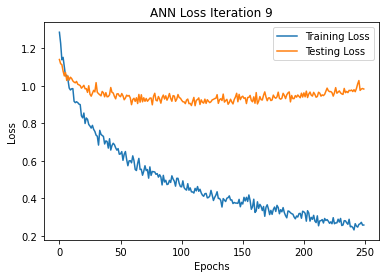

Test accuracy iteration 9: 60.60606060606061%
Test recall iteration 9: 63.2183908045977%




In [52]:
# Run the network 10 times to get average testing recall & accuracy

total_testing_rec = []
total_testing_acc = []

for i in range(10):
    network = ANN(training_features.shape[1]).cuda()
    train_dataset = AutismDataset(training_features, training_labels)
    train_iter = DataLoader(train_dataset, batch_size, shuffle=False, sampler=sampler)
    optimizer = torch.optim.SGD(network.parameters(), lr=lr, momentum=0.001)

    t_features = torch.from_numpy(testing_features).float()
    t_labels = torch.from_numpy(testing_labels).float().type(torch.LongTensor)

    train_loss = []
    test_loss = []

    max_rec = 0
    for epoch in range(250):
        running_acc = 0
        network.train()
        losses = []
        for inputs, labels in train_iter:
            inputs, labels = inputs.float().cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            out = torch.argmax(outputs.detach(), dim=1)
            acc = (out==labels).sum().item()
            running_acc += acc
        train_loss.append(np.mean(losses))
        correct = 0
        network.eval()
        with torch.no_grad():
            out = network(t_features.cuda()).cpu()
            test_loss.append(criterion(out, t_labels).item())
            out = torch.argmax(out, dim=1)
            correct += (out==t_labels).sum().item()
            acc = correct / len(t_labels)
            rec = recall_score(t_labels, out, labels=[0, 1], average='weighted')
            if rec > max_rec and epoch > 200:
                max_rec = rec
                best_val_model = deepcopy(network.state_dict())
        # just print every 10 epochs to reduce printing so much
        if epoch % 10 == 0:
            train_acc = running_acc * 100 / len(train_dataset)
            test_acc = correct * 100 / len(t_features)

            print(f"Epoch: {epoch} Train acc: {train_acc} Testing acc: {test_acc}")

    plt.plot(train_loss, label="Training Loss")
    plt.plot(test_loss, label="Testing Loss")
    plt.title(f"ANN Loss Iteration {i}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    correct = 0
    network.load_state_dict(best_val_model)
    network.eval()
    with torch.no_grad():
        out = network(t_features.cuda()).cpu()
        out = torch.argmax(out, dim=1)
        acc = (out==t_labels).sum().item()

    test_acc = (acc * 100) / len(t_labels)
    test_rec = recall_score(t_labels, out, labels=[0, 1], average='weighted')
    test_rec *= 100
    print(f"Test accuracy iteration {i}: {test_acc}%")
    print(f"Test recall iteration {i}: {test_rec}%\n\n")

    total_testing_rec.append(test_rec)
    total_testing_acc.append(test_acc)

In [53]:
print(f"Average Testing Recall over 10 iterations: {np.mean(total_testing_rec)}")
print(f"Average Testing Accuracy over 10 iteration: {np.mean(total_testing_acc)}")

Average Testing Recall over 10 iterations: 57.47126436781609
Average Testing Accuracy over 10 iteration: 59.19191919191919


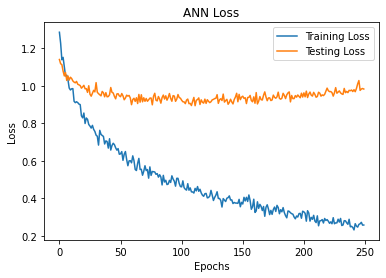

In [54]:
plt.plot(train_loss, label="Training Loss")
plt.plot(test_loss, label="Testing Loss")
plt.title("ANN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('ann_loss.png')
plt.show()

In [55]:
cr = classification_report(t_labels, out)
print(cr)

              precision    recall  f1-score   support

           0       0.25      0.21      0.23        19
           1       0.54      0.75      0.63        68
           2       0.74      0.59      0.65       111

    accuracy                           0.61       198
   macro avg       0.51      0.52      0.50       198
weighted avg       0.62      0.61      0.60       198



### Convolutional Neural Network (CNN)

In [56]:
class ConvNet(nn.Module):
    def __init__(self, input_dim, output_dim=3):
        super().__init__()
        self.convolutions = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2),
        )

        self.linear = nn.Sequential(
            nn.Linear(64 * 676, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, output_dim)
        )

    def forward(self, xb):
        xb = self.convolutions(xb)
        #print(xb.shape)
        xb = xb.view(-1, 64 * 676)
        xb = self.linear(xb)
        return xb

In [57]:
criterion = nn.CrossEntropyLoss()
batch_size = 32
lr = 0.001

labels_unique, counts = np.unique(training_labels, return_counts=True)
class_weights = [sum(counts) / c for c in counts]
example_weights = [class_weights[e] for e in training_labels]
sampler = WeightedRandomSampler(example_weights, len(training_labels))

Epoch: 0 Train acc: 33.67088607594937 Testing acc: 55.05050505050505
Epoch: 10 Train acc: 40.12658227848101 Testing acc: 25.252525252525253
Epoch: 20 Train acc: 43.924050632911396 Testing acc: 45.45454545454545
Epoch: 30 Train acc: 47.46835443037975 Testing acc: 58.08080808080808
Epoch: 40 Train acc: 50.88607594936709 Testing acc: 53.03030303030303
Epoch: 50 Train acc: 53.037974683544306 Testing acc: 57.07070707070707
Epoch: 60 Train acc: 60.0 Testing acc: 55.55555555555556
Epoch: 70 Train acc: 60.75949367088607 Testing acc: 56.06060606060606
Epoch: 80 Train acc: 59.74683544303797 Testing acc: 59.5959595959596
Epoch: 90 Train acc: 65.44303797468355 Testing acc: 50.0
Epoch: 100 Train acc: 68.22784810126582 Testing acc: 53.03030303030303
Epoch: 110 Train acc: 69.24050632911393 Testing acc: 56.56565656565657
Epoch: 120 Train acc: 72.40506329113924 Testing acc: 51.515151515151516
Epoch: 130 Train acc: 74.17721518987342 Testing acc: 57.57575757575758
Epoch: 140 Train acc: 77.0886075949367 T

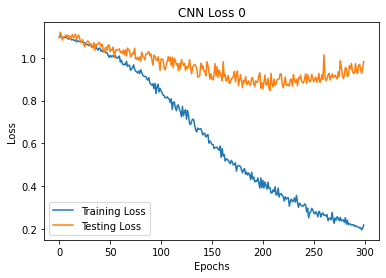

Test accuracy iteration 0: 51.515151515151516%
Test recall iteration 0: 60.91954022988506%


Epoch: 0 Train acc: 34.050632911392405 Testing acc: 55.55555555555556
Epoch: 10 Train acc: 41.139240506329116 Testing acc: 27.77777777777778
Epoch: 20 Train acc: 43.79746835443038 Testing acc: 57.57575757575758
Epoch: 30 Train acc: 45.949367088607595 Testing acc: 59.09090909090909
Epoch: 40 Train acc: 50.25316455696203 Testing acc: 53.535353535353536
Epoch: 50 Train acc: 54.55696202531646 Testing acc: 56.56565656565657
Epoch: 60 Train acc: 55.822784810126585 Testing acc: 53.03030303030303
Epoch: 70 Train acc: 60.50632911392405 Testing acc: 54.54545454545455
Epoch: 80 Train acc: 62.151898734177216 Testing acc: 53.535353535353536
Epoch: 90 Train acc: 62.40506329113924 Testing acc: 53.535353535353536
Epoch: 100 Train acc: 65.44303797468355 Testing acc: 50.0
Epoch: 110 Train acc: 70.75949367088607 Testing acc: 50.505050505050505
Epoch: 120 Train acc: 70.75949367088607 Testing acc: 54.04040404040404

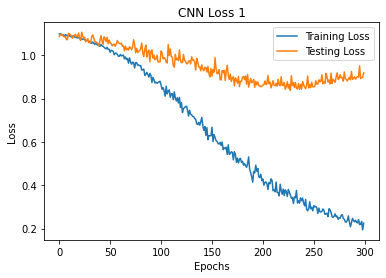

Test accuracy iteration 1: 57.57575757575758%
Test recall iteration 1: 60.91954022988506%


Epoch: 0 Train acc: 33.79746835443038 Testing acc: 54.54545454545455
Epoch: 10 Train acc: 37.21518987341772 Testing acc: 56.56565656565657
Epoch: 20 Train acc: 38.22784810126582 Testing acc: 58.58585858585859
Epoch: 30 Train acc: 42.0253164556962 Testing acc: 58.58585858585859
Epoch: 40 Train acc: 48.10126582278481 Testing acc: 58.08080808080808
Epoch: 50 Train acc: 49.49367088607595 Testing acc: 51.515151515151516
Epoch: 60 Train acc: 55.822784810126585 Testing acc: 57.57575757575758
Epoch: 70 Train acc: 52.91139240506329 Testing acc: 60.60606060606061
Epoch: 80 Train acc: 56.32911392405063 Testing acc: 57.57575757575758
Epoch: 90 Train acc: 56.20253164556962 Testing acc: 55.05050505050505
Epoch: 100 Train acc: 58.860759493670884 Testing acc: 56.56565656565657
Epoch: 110 Train acc: 61.392405063291136 Testing acc: 60.60606060606061
Epoch: 120 Train acc: 64.9367088607595 Testing acc: 53.535353535

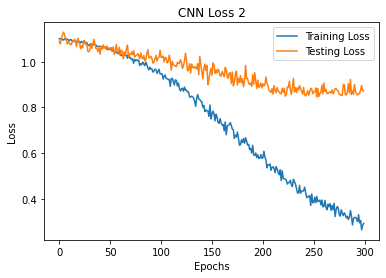

Test accuracy iteration 2: 54.04040404040404%
Test recall iteration 2: 59.77011494252874%


Epoch: 0 Train acc: 34.55696202531646 Testing acc: 56.06060606060606
Epoch: 10 Train acc: 41.51898734177215 Testing acc: 49.494949494949495
Epoch: 20 Train acc: 43.54430379746835 Testing acc: 58.08080808080808
Epoch: 30 Train acc: 49.87341772151899 Testing acc: 58.58585858585859
Epoch: 40 Train acc: 53.924050632911396 Testing acc: 57.57575757575758
Epoch: 50 Train acc: 54.81012658227848 Testing acc: 53.03030303030303
Epoch: 60 Train acc: 59.11392405063291 Testing acc: 53.03030303030303
Epoch: 70 Train acc: 62.65822784810127 Testing acc: 58.08080808080808
Epoch: 80 Train acc: 64.55696202531645 Testing acc: 56.06060606060606
Epoch: 90 Train acc: 66.07594936708861 Testing acc: 58.08080808080808
Epoch: 100 Train acc: 67.84810126582279 Testing acc: 55.55555555555556
Epoch: 110 Train acc: 72.53164556962025 Testing acc: 56.56565656565657
Epoch: 120 Train acc: 72.65822784810126 Testing acc: 56.565656565

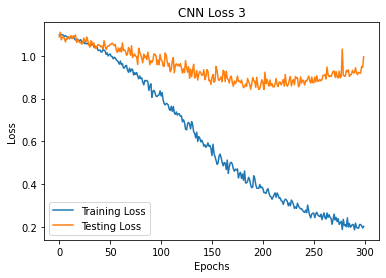

Test accuracy iteration 3: 55.55555555555556%
Test recall iteration 3: 63.2183908045977%


Epoch: 0 Train acc: 34.177215189873415 Testing acc: 34.343434343434346
Epoch: 10 Train acc: 40.63291139240506 Testing acc: 57.57575757575758
Epoch: 20 Train acc: 43.037974683544306 Testing acc: 58.58585858585859
Epoch: 30 Train acc: 49.24050632911393 Testing acc: 51.515151515151516
Epoch: 40 Train acc: 51.64556962025316 Testing acc: 59.09090909090909
Epoch: 50 Train acc: 58.734177215189874 Testing acc: 57.57575757575758
Epoch: 60 Train acc: 59.11392405063291 Testing acc: 55.05050505050505
Epoch: 70 Train acc: 61.392405063291136 Testing acc: 57.57575757575758
Epoch: 80 Train acc: 65.0632911392405 Testing acc: 51.515151515151516
Epoch: 90 Train acc: 64.30379746835443 Testing acc: 60.101010101010104
Epoch: 100 Train acc: 64.55696202531645 Testing acc: 56.06060606060606
Epoch: 110 Train acc: 68.22784810126582 Testing acc: 53.535353535353536
Epoch: 120 Train acc: 72.15189873417721 Testing acc: 57.5757

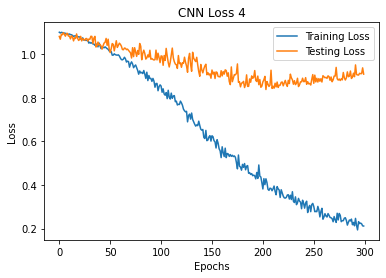

Test accuracy iteration 4: 56.06060606060606%
Test recall iteration 4: 59.77011494252874%


Epoch: 0 Train acc: 33.79746835443038 Testing acc: 34.343434343434346
Epoch: 10 Train acc: 39.36708860759494 Testing acc: 54.04040404040404
Epoch: 20 Train acc: 40.75949367088607 Testing acc: 56.06060606060606
Epoch: 30 Train acc: 48.860759493670884 Testing acc: 47.474747474747474
Epoch: 40 Train acc: 51.265822784810126 Testing acc: 59.09090909090909
Epoch: 50 Train acc: 57.46835443037975 Testing acc: 43.93939393939394
Epoch: 60 Train acc: 61.77215189873418 Testing acc: 52.02020202020202
Epoch: 70 Train acc: 59.49367088607595 Testing acc: 55.55555555555556
Epoch: 80 Train acc: 61.64556962025316 Testing acc: 54.54545454545455
Epoch: 90 Train acc: 64.68354430379746 Testing acc: 51.515151515151516
Epoch: 100 Train acc: 68.48101265822785 Testing acc: 52.02020202020202
Epoch: 110 Train acc: 72.0253164556962 Testing acc: 54.54545454545455
Epoch: 120 Train acc: 75.31645569620254 Testing acc: 49.4949494

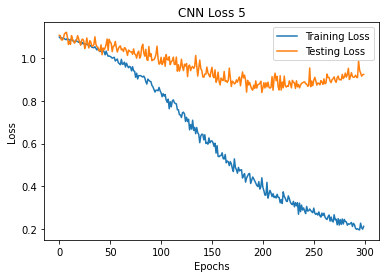

Test accuracy iteration 5: 57.07070707070707%
Test recall iteration 5: 60.91954022988506%


Epoch: 0 Train acc: 31.518987341772153 Testing acc: 37.37373737373738
Epoch: 10 Train acc: 36.20253164556962 Testing acc: 50.505050505050505
Epoch: 20 Train acc: 46.45569620253165 Testing acc: 57.07070707070707
Epoch: 30 Train acc: 48.48101265822785 Testing acc: 57.57575757575758
Epoch: 40 Train acc: 51.51898734177215 Testing acc: 53.535353535353536
Epoch: 50 Train acc: 58.10126582278481 Testing acc: 51.515151515151516
Epoch: 60 Train acc: 59.74683544303797 Testing acc: 58.08080808080808
Epoch: 70 Train acc: 65.44303797468355 Testing acc: 56.06060606060606
Epoch: 80 Train acc: 66.83544303797468 Testing acc: 56.56565656565657
Epoch: 90 Train acc: 69.49367088607595 Testing acc: 51.515151515151516
Epoch: 100 Train acc: 74.17721518987342 Testing acc: 51.515151515151516
Epoch: 110 Train acc: 74.9367088607595 Testing acc: 55.05050505050505
Epoch: 120 Train acc: 77.72151898734177 Testing acc: 53.535353

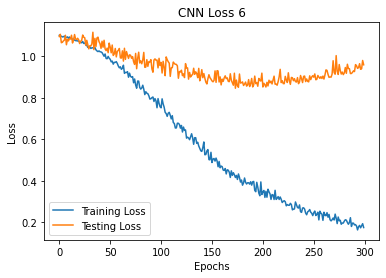

Test accuracy iteration 6: 56.56565656565657%
Test recall iteration 6: 60.91954022988506%


Epoch: 0 Train acc: 35.18987341772152 Testing acc: 11.616161616161616
Epoch: 10 Train acc: 39.74683544303797 Testing acc: 19.19191919191919
Epoch: 20 Train acc: 44.81012658227848 Testing acc: 61.111111111111114
Epoch: 30 Train acc: 48.734177215189874 Testing acc: 51.01010101010101
Epoch: 40 Train acc: 50.75949367088607 Testing acc: 51.515151515151516
Epoch: 50 Train acc: 54.050632911392405 Testing acc: 56.56565656565657
Epoch: 60 Train acc: 55.31645569620253 Testing acc: 59.09090909090909
Epoch: 70 Train acc: 62.151898734177216 Testing acc: 56.56565656565657
Epoch: 80 Train acc: 57.9746835443038 Testing acc: 56.06060606060606
Epoch: 90 Train acc: 62.78481012658228 Testing acc: 56.56565656565657
Epoch: 100 Train acc: 63.79746835443038 Testing acc: 54.54545454545455
Epoch: 110 Train acc: 68.10126582278481 Testing acc: 57.07070707070707
Epoch: 120 Train acc: 71.89873417721519 Testing acc: 50.505050

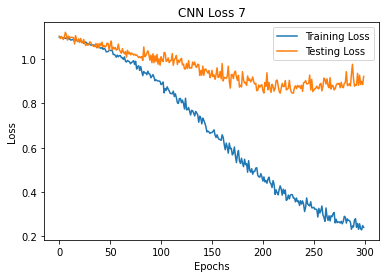

Test accuracy iteration 7: 55.55555555555556%
Test recall iteration 7: 59.77011494252874%


Epoch: 0 Train acc: 35.18987341772152 Testing acc: 11.11111111111111
Epoch: 10 Train acc: 37.721518987341774 Testing acc: 55.55555555555556
Epoch: 20 Train acc: 44.936708860759495 Testing acc: 56.06060606060606
Epoch: 30 Train acc: 48.734177215189874 Testing acc: 58.58585858585859
Epoch: 40 Train acc: 57.08860759493671 Testing acc: 42.92929292929293
Epoch: 50 Train acc: 56.20253164556962 Testing acc: 58.08080808080808
Epoch: 60 Train acc: 60.12658227848101 Testing acc: 46.464646464646464
Epoch: 70 Train acc: 56.58227848101266 Testing acc: 55.55555555555556
Epoch: 80 Train acc: 64.30379746835443 Testing acc: 58.58585858585859
Epoch: 90 Train acc: 65.9493670886076 Testing acc: 55.05050505050505
Epoch: 100 Train acc: 67.21518987341773 Testing acc: 50.505050505050505
Epoch: 110 Train acc: 73.41772151898734 Testing acc: 49.494949494949495
Epoch: 120 Train acc: 74.30379746835443 Testing acc: 48.989898

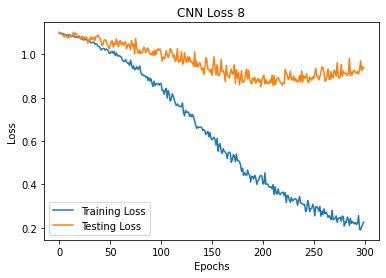

Test accuracy iteration 8: 56.06060606060606%
Test recall iteration 8: 59.77011494252874%


Epoch: 0 Train acc: 31.772151898734176 Testing acc: 30.80808080808081
Epoch: 10 Train acc: 39.11392405063291 Testing acc: 11.616161616161616
Epoch: 20 Train acc: 42.278481012658226 Testing acc: 58.58585858585859
Epoch: 30 Train acc: 47.9746835443038 Testing acc: 29.292929292929294
Epoch: 40 Train acc: 53.164556962025316 Testing acc: 57.57575757575758
Epoch: 50 Train acc: 53.924050632911396 Testing acc: 58.08080808080808
Epoch: 60 Train acc: 55.44303797468354 Testing acc: 57.07070707070707
Epoch: 70 Train acc: 57.08860759493671 Testing acc: 48.98989898989899
Epoch: 80 Train acc: 61.0126582278481 Testing acc: 55.55555555555556
Epoch: 90 Train acc: 63.924050632911396 Testing acc: 50.505050505050505
Epoch: 100 Train acc: 67.0886075949367 Testing acc: 56.56565656565657
Epoch: 110 Train acc: 69.74683544303798 Testing acc: 54.54545454545455
Epoch: 120 Train acc: 70.37974683544304 Testing acc: 58.080808

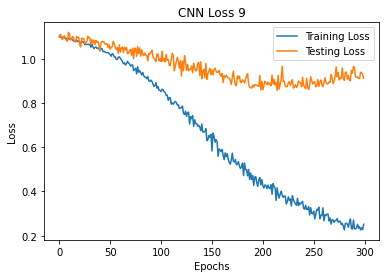

Test accuracy iteration 9: 55.05050505050505%
Test recall iteration 9: 60.91954022988506%




In [58]:
total_testing_rec_conv = []
total_testing_acc_conv = []

for i in range(10):
    network = ConvNet(training_features.shape[1]).cuda()
    train_dataset = AutismDataset(training_features, training_labels)
    train_iter = DataLoader(train_dataset, batch_size, shuffle=False, sampler=sampler)

    optimizer = torch.optim.SGD(network.parameters(), lr=lr, momentum=0.001)

    t_features = torch.from_numpy(testing_features).float()
    t_labels = torch.from_numpy(testing_labels).float().type(torch.LongTensor)

    train_loss = []
    test_loss = []

    max_rec = 0
    for epoch in range(300):
        running_acc = 0
        network.train()
        losses = []
        for inputs, labels in train_iter:
            inputs, labels = inputs.float().cuda(), labels.cuda()
            inputs = inputs.unsqueeze(1)
            optimizer.zero_grad()
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            out = torch.argmax(outputs.detach(), dim=1)
            acc = (out==labels).sum().item()
            running_acc += acc
        train_loss.append(np.mean(losses))
        correct = 0
        network.eval()
        with torch.no_grad():
            if len(t_features.shape) == 2:
                t_features = t_features.unsqueeze(1)
            out = network(t_features.cuda()).cpu()
            test_loss.append(criterion(out, t_labels).item())
            out = torch.argmax(out, dim=1)
            correct += (out==t_labels).sum().item()
            acc = correct / len(t_labels)
            rec = recall_score(t_labels, out, labels=[0, 1], average='weighted')
            if rec > max_rec and epoch > 250:
                max_rec = rec
                best_val_model = deepcopy(network.state_dict())
        if epoch % 10 == 0:
            train_acc = running_acc * 100 / len(train_dataset)
            test_acc = correct * 100 / len(t_features)

            print(f"Epoch: {epoch} Train acc: {train_acc} Testing acc: {test_acc}")

    plt.plot(train_loss, label="Training Loss")
    plt.plot(test_loss, label="Testing Loss")
    plt.title(f"CNN Loss {i}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    correct = 0
    network.load_state_dict(best_val_model)
    network.eval()
    with torch.no_grad():
        out = network(t_features.cuda()).cpu()
        out = torch.argmax(out, dim=1)
        acc = (out==t_labels).sum().item()
    test_acc = (acc * 100) / len(t_labels)
    test_recall = recall_score(t_labels, out, labels=[0, 1], average='weighted')
    test_recall *= 100

    print(f"Test accuracy iteration {i}: {test_acc}%")
    print(f"Test recall iteration {i}: {test_recall}%\n\n")

    total_testing_acc_conv.append(test_acc)
    total_testing_rec_conv.append(test_recall)

In [59]:
print(f"Average Testing Recall over 10 iterations: {np.mean(total_testing_rec_conv)}")
print(f"Average Testing Accuracy over 10 iteration: {np.mean(total_testing_acc_conv)}")

Average Testing Recall over 10 iterations: 60.689655172413794
Average Testing Accuracy over 10 iteration: 55.505050505050505


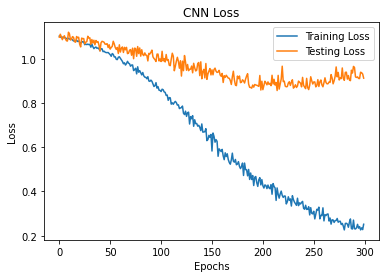

In [60]:
plt.plot(train_loss, label="Training Loss")
plt.plot(test_loss, label="Testing Loss")
plt.title("CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('cnn_loss.png')
plt.show()

In [61]:
cr = classification_report(t_labels, out)
print(cr)

              precision    recall  f1-score   support

           0       0.21      0.16      0.18        19
           1       0.46      0.74      0.57        68
           2       0.74      0.50      0.60       111

    accuracy                           0.55       198
   macro avg       0.47      0.47      0.45       198
weighted avg       0.59      0.55      0.55       198

